# Data 607 Project Proposal
## Image Classification for Amazon Products

Team - YongPeng Fu, Stuart Finley, Sneha Arora

**Purpose**
We will use our own customized web scraping tool to download thousands of images from Amazon for a range of human wearable products, including Earbuds, VR sets, Fitness trackers, Hearing Aids, Watches, Sunglasses, and Hats. Our purpose is to build a model that can accurately classify the products in the images.

**Questions to Analyse**
1. How do conventional machine learning techniques compare to neural networks for image analysis and classification?
2. What are the effects of using dimensionality reduction for image classification?
3. Can we come to a final best-suited model to tag images for human wearable products? 
							
**Methodology**
Data preprocessing is required prior to building models, and the images need labelling based on the product category to which they belong. Currently, the images reside in their respective folders, where the folder will be the label name for the image. For each image, colours will be removed. In addition, Images will need to be resized to a standard size, and pixel values normalized to a range of [0, 1]. Then, the data is split into training and validation sets, where the training set is to be used to train the model, and the validation set is used to evaluate the performance of the model during training.
As an exploration step, we will first use conventional machine learning models including logistic regression, K-nearest neighbours (KNN), support vector machines (SVM), Gaussian Bayes Classifier, and tree-based classifiers. These models will be trained using the labelled images, and their performance will be evaluated on a validation dataset. 
To reduce computational power and improve the efficiency of our models,  dimensionality reduction will be implemented using Principal Component Analysis (PCA), where the complexity of the image data is reduced through the identification of the most important pixels. We can then evaluate the effectiveness of using dimensionality for image classification by applying each trained model to validation sets.
Our team will explore the use of deep learning methods like Convolutional Neural Networks (CNN) to classify images. These models apply convolutional filters to the input image, which extract features at different spatial scales. The extracted features are then fed into a series of fully connected layers that perform the classification task. The model's output is a softmax layer that predicts the probability distribution over the product categories.
CNN is explored later in this course, but our team will do preliminary work to build a CNN model for image classification, which we can refine further using the additional materials we learn. 

**Challenges**
	Our team's challenge is the number of images available for training the model in each class. For each product search on Amazon, around 330 images are returned. It is estimated that for a good image classification model, ~500 images [1]  are required for training. To overcome this hurdle, our training data may need to be augmented by randomly cropping, rotating, brightening, or warping the original images. This can effectively increase the size of our training sets for each class.


**References**

[1] Falzon, G., Meek, P., & Shahinfar, S. (2020, March 19). "How many images do I need?" understanding how sample size per class affects deep learning model performance metrics for balanced designs in autonomous wildlife monitoring. Retrieved March 22, 2023, from https://www.sciencedirect.com/science/article/abs/pii/S1574954120300352 


## Outline of the project
First we will try a range of conventional machine learning models like Random Forest Classifier, KNN, Decision Tree Classifier, and Naive Bayes classifier. Later on we will also implement Deep Learning like CNN.

The overall layout for this analysis is:
1. import all required packages
2. Load the data and label each image
3. Visualialize some figures and process them
4. Try differetnt machine learning modesl, find the best hypter parameters, and evaluate respective performance
5. Use the trained model to do some prediction

## Load required packages

In [1]:
import numpy as np
import random
import pandas as pd
import seaborn as sb
from matplotlib import pyplot as plt

from pathlib import Path
import os
import re

#need to pip install opencv-python
import cv2
from skimage.color import rgb2gray #convert RGB to gray color

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.utils import shuffle

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

#You need scikit-optimize to run Bayesian Optimization faster.
# !pip install scikit-optimize
from skopt import BayesSearchCV

In [2]:
# #Access Google Drive from Google Colab
# from google.colab import drive
# drive.mount('/content/gdrive')

# #Remove some unnecessary folder since I will move everyting to colab
# import shutil

# # Deleting an non-empty folder
# dir_path = ["./Images+augmentation/ImageFolder2/" + classes +"/augmented_rotate" for classes in class_names]
# for every_path in dir_path:
#     shutil.rmtree(every_path, ignore_errors=True)
#     print("Deleted '%s' directory successfully" % every_path)

In [2]:
#Get the total classes we have
class_names = [class_name for class_name in os.listdir("./Images+augmentation/ImageFolder2") if not class_name.startswith(".")]
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)
IMAGE_SIZE = (150, 150)
print(f"We have in total {nb_classes} different classes."+
      f"\nAnd they are:\n {', '.join(classes for classes in class_names)}.")

We have in total 11 different classes.
And they are:
 tshirt, sunglasses, watches, speaker, chair, shorts, phone, earbuds, hat, shoes, bottle.


## Explore cv2 package

The original image has shape of (218, 214, 3) with datatype of uint8
The image after converting into gray color has shape of (218, 214) with datatype of float64
The image after resizing has shape of (150, 150, 3) with datatype of uint8


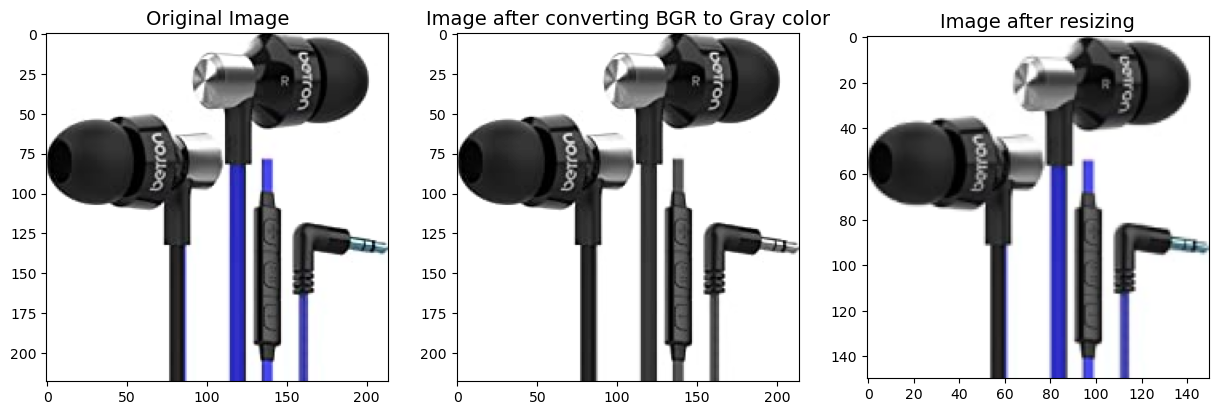

In [3]:
# '''
# OS.walk() generate the file names in a directory tree by walking the tree either top-down or bottom-up.
# For each directory in the tree rooted at directory top (including top itself), 
# it yields a 3-tuple (dirpath, dirnames, filenames).
# For example, we have 12 folder in ./images, it will loop through 13 times = root + 12 folders
# Read more in https://www.geeksforgeeks.org/os-walk-python/
# '''
# class_name = []
# for root, dirs, files in os.walk("./images", topdown = True):
#     for name in files:
#         print(os.path.join(root, name))

# for i in range(10):
#     plt.imshow(images[i].astype('uint8'))

fig, axes = plt.subplots(1, 3, figsize=(15, 6))
#Read in one image and show them
test_img1 = cv2.imread("./Images+augmentation/ImageFolder2/earbuds/615MxN+QWzL.jpg")
#The original image
print(f"The original image has shape of {test_img1.shape} with datatype of {test_img1.dtype}")
axes[0].imshow(test_img1)
axes[0].set_title("Original Image", fontsize=14)
#After change the color space from BGR to RGB
'''
When the image file is read with the OpenCV function imread(), the order of colors is BGR (blue, green, red). 
On the other hand, in Pillow, the order of colors is assumed to be RGB (red, green, blue).
Therefore, if you want to use both the Pillow function and the OpenCV function, you need to convert BGR and RGB.
'''
'''
When reading a color image file, OpenCV imread() reads as a NumPy array ndarray of 
row (height) x column (width) x color (3). The order of color is BGR (blue, green, red).
read more in https://note.nkmk.me/en/python-opencv-bgr-rgb-cvtcolor/

test_img2 = cv2.cvtColor(test_img1, cv2.COLOR_BGR2RGB)
'''
'''
Reducing computational demand:
With interest in minimizing cost, it is best to only retain the information required for the task in question.
Common ways to carry out this step include reducing image size and removing color. 
In many cases, such a level of detail is not needed for the model to perform well.

For example, when comparing cats and dogs, color is not really a deciding factor. 
You can easily build a model that distinguishes between the two species without colored images.

Here, the Skimage package is used to remove color from the cat image.
'''
test_img2 = rgb2gray(test_img1)
axes[1].imshow(test_img2, cmap=plt.cm.gray)
axes[1].set_title("Image after converting BGR to Gray color", fontsize=14)
print(f"The image after converting into gray color has shape of {test_img2.shape} with datatype of {test_img2.dtype}")
'''
OpenCV provides the function cv2. resize() to resize an image. Resizing in OpenCV 
is referred to as scaling. We can resize an image by specifying the image size or scaling factor. 
The aspect ratio is preserved when we specify the scaling factor.
'''
test_img3 = cv2.resize(test_img1, (150,150))
axes[2].imshow(test_img3)
axes[2].set_title("Image after resizing", fontsize=14)
print(f"The image after resizing has shape of {test_img3.shape} with datatype of {test_img3.dtype}")
plt.show()

## Load Data
Based on previous test, we can do the following steps to reduce the computational demand:
1. Removing color (potentially)
2. Reducing image size

In [4]:
#Load the data from each folder
def load_image_from_folder(root_dir, max_img_perclass = 4000):

    images = []
    labels = []
    IMAGE_SIZE = (150, 150)

    for folder in os.listdir(root_dir):
        #Because there are some configure file also sitting there  
        if folder.startswith("."):
            continue
        label = class_names_label[folder]
        total_img_perclass = 0
        for root, dirs, files in os.walk(os.path.join(root_dir, folder), topdown = True):
            # Get the path name of the image
            for file in files:
                img_path = os.path.join(root,file)
                #open and resize the image, read in as 3d array
                '''
                The reason we add try except is because some iamges just cannot be read in to cv2
                for example this one: ./updated images/watches/712+lS1mk-L._AC_UL320_.jpg
                I dont know why.

                Also, there are some corrupted images like this one: ./updated images/watches/814cT4PAxeL._AC_UL320_.jpg
                However, cv2 wont allow us to capture this images. We will still keep them in our image pool,
                because they dont really cause any issue.

                If you do want learn more read https://medium.com/joelthchao/programmatically-detect-corrupted-image-8c1b2006c3d3
                and
                https://scikit-image.org/
                '''
                try:
                    image = cv2.imread(img_path)
                    #cv2.cvtColor() method is used to convert an image from one color space to another.
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    
                    #OpenCV provides the function cv2. resize() to resize an image. Resizing in OpenCV 
                    #is referred to as scaling. We can resize an image by specifying the image size or scaling factor. 
                    #The aspect ratio is preserved when we specify the scaling factor.
                    image = cv2.resize(image, IMAGE_SIZE)
                except:
                    continue
                
                total_img_perclass += 1
                if total_img_perclass > max_img_perclass:
                    break
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
    # The original dtypes of image is uint8 (Unsigned integer type, from 0 to 18_446_744_073_709_551_615)
    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')

    return ((images, labels))

In [5]:
images, labels = load_image_from_folder('./Images+augmentation/ImageFolder2',max_img_perclass = 600)

#Shuffle arrays or sparse matrices in a consistent way.
#This is a convenience alias to resample(*arrays, replace=False) to do random permutations of the collections.
#otherwise imaages are grouped all together based on their classes
images_r, labels_r = shuffle(images, labels, random_state=25)

Corrupt JPEG data: 1955 extraneous bytes before marker 0xc4
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 2472 extraneous bytes before marker 0xc4
Corrupt JPEG data: 897 extraneous bytes before marker 0xc4
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1003 extraneous bytes before marker 0xc4
Corrupt JPEG data: 1312 extraneous bytes before marker 0xc4
Corrupt JPEG data: bad Huffman code


## How to find duplicated images
Since we are pulling more images from Amazon Country, maybe there are some duplicated images. We will write a function to find those images and only keep one of duplicated images.

This is done by leveraing the fact that duplicated images has very similar naming.

## Visualization

How many images in each class?


,,,,,,,,,,,
Class,bottle,chair,earbuds,hat,phone,shoes,shorts,speaker,sunglasses,tshirt,watches
Total Amount,600,600,600,600,600,600,600,600,600,600,600


Each image size is: (150, 150).


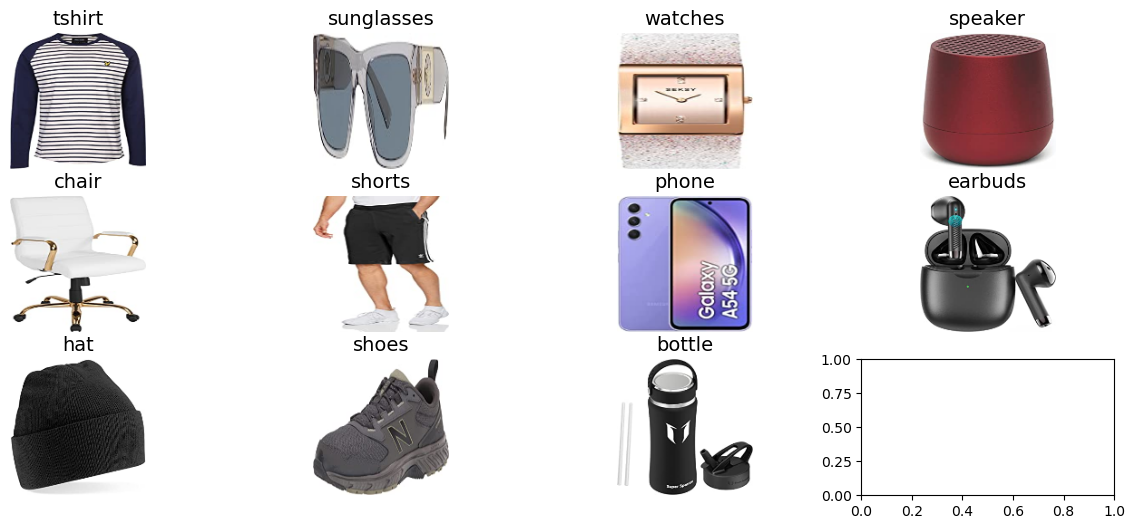

In [6]:
'''
How many images in each class?
'''
print("How many images in each class?")
class_name, count_name = np.array(np.unique(np.array(class_names)[labels_r], return_counts=True))
total_images = pd.DataFrame((class_name, count_name), 
             index = ["Class", "Total Amount"], columns = ['']*len(class_name))
display(total_images)

print(f"Each image size is: {IMAGE_SIZE}.")

#Display the one image from each class
fig, axes = plt.subplots(3, 4, figsize=(15, 6))
for i, ax in enumerate(axes.ravel()[:-1]):
    #This will only look at one image for each different category
    #we also remove the image colours to demonstrate
    x = images_r[labels_r == i][0].astype('uint8')
    ax.imshow(x,cmap=plt.cm.gray)
    ax.set_axis_off()
    ax.set_title(f"{class_names[i]}", fontsize=14)

## Preprocessing
Normalization is a common step of image pre-processing and is achieved by simply dividing images by 255.0. This is essential to maintain the pixels of all the images within a uniform range.

The shape of images is in 4 dimensions like (44000, 150, 150, 3)=(nsamples, nx, ny, nrgb) , meaing there are total 44000 images and each image has (150, 150, 3) shape.

1. nrgb = 3 means there are 3 channels to make the image colourful. However, as demonstrated before, we dont really need color to differentiate image category. We will convert rgb to gray to reduce computational demond then.
2. The Sklearn machine leraning models are expecting 2 dimensions, with row as each image information.

Read more:
- https://www.analyticsvidhya.com/blog/2022/01/image-classification-using-machine-learning/
- https://towardsdatascience.com/3-things-you-need-to-know-before-working-with-images-in-machine-learning-6a2ab6f6b822#:~:text=Running%20machine%20learning%20models&text=Convolutional%20neural%20networks%20only%20function,common%20practice%20in%20computer%20vision
- https://towardsdatascience.com/3-things-you-need-to-know-before-working-with-images-in-machine-learning-6a2ab6f6b822#:~:text=Running%20machine%20learning%20models&text=Convolutional%20neural%20networks%20only%20function,common%20practice%20in%20computer%20vision.

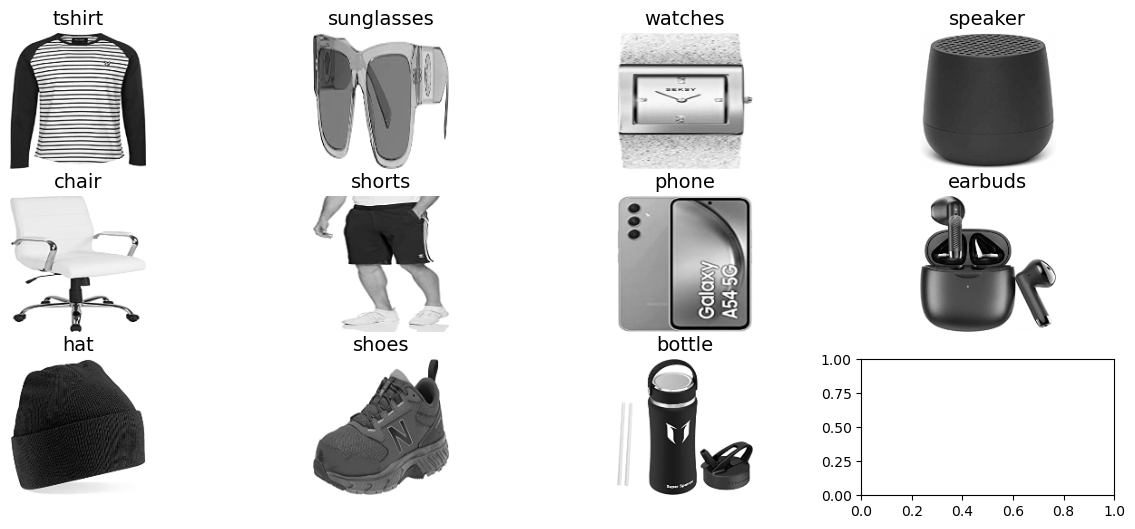

In [7]:
#1: remove colours
images_r_g = np.zeros(images_r.shape[0:3])
for i in range(images_r.shape[0]):
    images_r_g[i] = rgb2gray(images_r[i])
    
#Display the one image from each class
fig, axes = plt.subplots(3, 4, figsize=(15, 6))
for i, ax in enumerate(axes.ravel()[:-1]):
    #This will only look at one image for each different category
    #we also remove the image colours to demonstrate
    #x = images_r[labels_r == i][0].astype('uint8')
    x = images_r_g[labels_r == i][0]
    ax.imshow(x,cmap=plt.cm.gray)
    ax.set_axis_off()
    ax.set_title(f"{class_names[i]}", fontsize=14)

In [8]:
# Split the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(images_r_g, labels_r, test_size=0.2, random_state=2023)

# Normalization
X_train_norm = X_train/255.0
X_test_norm = X_test/255.0

#reshape
nsamples, nx, ny = X_train_norm.shape
X_train_norm = X_train_norm.reshape((nsamples, nx*ny))
nsamples, nx, ny = X_test_norm.shape
X_test_norm = X_test_norm.reshape((nsamples, nx*ny))

#look at the shaoe of training and testing
X_train_norm.shape, X_test_norm.shape

((5280, 22500), (1320, 22500))

## Implementing different machine learning models
1. Logistic regression
2. K-Nearest Neighbours
3. LDA / QDA / Gaussian Naive Bayes
4. PCA (will be used to combine with other method)
5. Support Vector Machine
6. Trees (DecisionTreeClassifier, Bagging and Random Forests, Boosting, Bayesian Additive Regression Trees (BART))
7. Neural Networks

Learn more in https://www.analyticsvidhya.com/blog/2022/01/image-classification-using-machine-learning/

Each method we need to do cross validation (Kfold), hyper parameter tunning methods, or CVGridSearch. The following is a diagram of k-fold cross-validation.
![k-fold cross validation](./Archive/k-fold-cross-validation.png)

### Logistic regression (NOTE, to save time, I only use 600 images from each category)
We will fit the model and compute the score 5 consecutive times (with different splits each time). Because our samples are balanced across target classes ence the accuracy and the F1-score are almost equal.

In [12]:
import warnings
warnings.filterwarnings("ignore")
'''
The reason I want to ignore any warnings is because we got the following warning:
ConvergenceWarning: lbfgs failed to converge (status=1): STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

There are a few solutions to this:
    Increase the number of iterations;
    Try a different optimizer;
    Scale your data;
    Add engineered features;
    Data pre-processing;
    Add more data.

We did try a few of them, but we have to balance between computation power and finding the best model.
Since our single computer is not powerful enough, we can only try as much as we can.
'''

# 1: normalize the data
images_r_g_scaled = images_r_g/255.0
IMAGE_SIZE = (150, 150)

# 2: apply cross validation for logistic regression
scores = cross_val_score(LogisticRegression(), 
                         images_r_g_scaled.reshape(-1,150*150), 
                         labels_r, cv=5, scoring="accuracy")
print("The accuracy rate using logistic regression is: %0.2f accuracy with a standard deviation of %0.2f"
      % (scores.mean(), scores.std()))
#The accuracy rate using logistic regression is: 0.63 accuracy with a standard deviation of 0.01

The accuracy rate using logistic regression is: 0.62 accuracy with a standard deviation of 0.01


In [10]:
#We are using BayesSearchCV instead of GridSearchCV to find the best parameters
#Also we are using Scikit-Optimize for Hyperparameter Tuning to speed up the search
#https://machinelearningmastery.com/scikit-optimize-for-hyperparameter-tuning-in-machine-learning/
import warnings
warnings.filterwarnings("ignore")

# 3: Using  Bayesian Optimization to find an optimal LogisticRegression fit for the training set.
parameters = {'solver':("newton-cg", "sag", "saga", "lbfgs"), 'max_iter':(100, 500)}
lr = LogisticRegression()
#n_jobs = -1: use all available processors
glr = BayesSearchCV(lr, parameters, scoring='accuracy', cv= 5, n_jobs = -1)
glr.fit(X_train_norm, y_train)
print("The best values for solver and max_iter are", glr.best_params_, ".")
# print(accuracy_score(y_validation_ori, clf.predict(scale_X_validation_ori)))
print(f"The accuracy rate on the test set using logistic regression is {glr.score(X_test_norm, y_test):.2f}.")

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Split the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(images_r_g, labels_r, test_size=0.2, random_state=2023)
# # Normalization
X_train_scaled = X_train/255.0
X_test_scaled = X_test/255.0
#reshape
nsamples, nx, ny = X_train_scaled.shape
X_train_scaled = X_train_scaled.reshape((nsamples, nx*ny))
nsamples, nx, ny = X_test_scaled.shape
X_test_scaled = X_test_scaled.reshape((nsamples, nx*ny))

#Read pipelining in https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html

# 3: Using a cross-validated grid search (GridSeachCV), find an optimal LogisticRegression fit to the training set.
parameters = {'solver':("newton-cg", "sag", "saga","lbfgs"), 'max_iter':(100, 500)}
lr = LogisticRegression()
#n_jobs = -1: use all available processors
glr = GridSearchCV(lr, parameters, scoring='accuracy', cv= 5, n_jobs = -1)
glr.fit(X_train_scaled, y_train)
print("The best values for solver and max_iter are", glr.best_params_, ".")
# print(accuracy_score(y_validation_ori, clf.predict(scale_X_validation_ori)))
print(f"The accuracy rate on the test set using logistic regression is {glr.score(X_test_scaled, y_test):.2f}.")


### Tree (NOTE, to save time, I only use 600 images from each category)
We will try a few different trees to do classification:
1. DecisionTreeClassifier
2. Bagging for classification tree
3. Random Forests for classification tree
4. Boosting (only for regression)
5. Bayesian Additive Regression Trees (BART) (only for regression)

#### DecisionTreeClassifier

In [16]:
import warnings
warnings.filterwarnings("ignore")

# 1: normalize the data
images_r_g_scaled = images_r_g/255.0
IMAGE_SIZE = (150, 150)

# 2: apply cross validation for DecisionTreeClassifier
criteria = "gini"
max_depth = 6

scores = cross_val_score(DecisionTreeClassifier(criterion=criteria, random_state=2023,max_depth=max_depth), 
                         images_r_g_scaled.reshape(-1,150*150), 
                         labels_r, cv=5, scoring="accuracy")
print("The accuracy rate using DecisionTreeClassifier is: %0.2f accuracy with a standard deviation of %0.2f"
      % (scores.mean(), scores.std()))
#The accuracy rate using DecisionTreeClassifier is: 0.51 accuracy with a standard deviation of 0.01

The accuracy rate using DecisionTreeClassifier is: 0.51 accuracy with a standard deviation of 0.01


In [ ]:
'''
Decide which parameters to finetune, you can look at the following articles:
https://www.datacamp.com/tutorial/decision-tree-classification-python
https://www.projectpro.io/recipes/optimize-hyper-parameters-of-decisiontree-model-using-grid-search-in-python
https://medium.com/@mohtedibf/indepth-parameter-tuning-for-decision-tree-6753118a03c3
#https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html
'''
# Split the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(images_r_g, labels_r, test_size=0.2, random_state=2023)
# # Normalization
X_train_scaled = X_train/255.0
X_test_scaled = X_test/255.0
#reshape
nsamples, nx, ny = X_train_scaled.shape
X_train_scaled = X_train_scaled.reshape((nsamples, nx*ny))
nsamples, nx, ny = X_test_scaled.shape
X_test_scaled = X_test_scaled.reshape((nsamples, nx*ny))

# To build a tree, we could use 'gini' or 'entropy' as split criterion at each node.
#max_depth indicates how deep the tree can be. The deeper the tree, 
#the more splits it has and it captures more information about the data.
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12, 14, 16, 18, 20]
parameters = {'criterion':criterion, 'max_depth':max_depth}
dtc = DecisionTreeClassifier()

#Read pipelining in https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html
# Using a cross-validated grid search (GridSeachCV), find an optimal DecisionTreeClassifier fit to the training set.
#n_jobs = -1: use all available processors
gdtc = GridSearchCV(dtc, parameters, scoring='accuracy', cv= 5, n_jobs = -1)
gdtc.fit(X_train_scaled, y_train)
print("The best values for criterion and max_depth are", gdtc.best_params_, ".")
# print(accuracy_score(y_validation_ori, clf.predict(scale_X_validation_ori)))
print(f"The accuracy rate on the test set using DecisionTreeClassifier is {gdtc.score(X_test_scaled, y_test):.2f}.")

In [ ]:
'''
Alternatively, we will use repeated  𝑘 -fold cross validation to find the best parameters:
'''
# Split the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(images_r_g, labels_r, test_size=0.2, random_state=2023)
# # Normalization
X_train_scaled = X_train/255.0
X_test_scaled = X_test/255.0
#reshape
nsamples, nx, ny = X_train_scaled.shape
X_train_scaled = X_train_scaled.reshape((nsamples, nx*ny))
nsamples, nx, ny = X_test_scaled.shape
X_test_scaled = X_test_scaled.reshape((nsamples, nx*ny))

max_depths = np.arange(2, 22, 2)
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html
'''
Try gini first.
'''
n_splits = 5
n_repeats = 40
accs_val = np.zeros((n_splits*n_repeats, len(max_depths)))
#Repeats K-Fold n times with different randomization in each repetition.
for j, k in enumerate(max_depths):
    #n_splits: Number of folds
    #basically it says create a 5 fold cross validator and repeat each cross validaiton 40 times
    #it is cross-validation + repeat for each cross-validation
    rkcv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=2023)
    #split(X[, y, groups]) Generates indices to split data into training and test set.
    splits = rkcv.split(X_train_scaled, y_train)
    
    # i = n_splits * n_repeats
    for i, (I_tr, I_val) in enumerate(splits):
        #for each max_depth, you have n_splits * n_repeats cross validation, n_splits * n_repeats accuracy
        model = DecisionTreeClassifier(max_depth=k, criterion='gini')
        model.fit(X_train_scaled[I_tr], y_train[I_tr])
        accs_val[i, j] = accuracy_score(y_train[I_val], model.predict(X_train_scaled[I_val]))

scores = accs_val.mean(axis=0)
max_depth_optimal = max_depths[scores.argmax()]

print("The max_depth in DecisionTreeClassifier that produces the highest accuracy is " + str(max_depth_optimal))
#The optimal value for max_depth is the one that maximize the accuracy rate, averaged over all 200 splittings.
plt.figure(figsize=(10,4))
plt.plot(max_depths, scores,'k', label="The average accuracy rate", lw=2)
plt.title("The average accuracy rate, averaged over all 200 splittings using DecisionTreeClassifier and gini criterion", 
          fontsize=10)
plt.xlabel('max_depth for DecisionTreeClassifier')
plt.ylabel('The average accuracy rate in DecisionTreeClassifier')
plt.vlines(max_depth_optimal, *plt.ylim(), colors="k", linestyles=":", 
           label=f"max. the average accuracy rate, $k$={max_depth_optimal}")
plt.legend()
plt.show()

#refit the model on the original training set and compute the accuracy rate on the test set.
model = DecisionTreeClassifier(max_depth=max_depth_optimal, criterion='gini')
model.fit(X_train_scaled, y_train)
test_accuracy = accuracy_score(y_test, model.predict(X_test_scaled))
print(f"The accuracy rate on the test set using DecisionTreeClassifier and gini criterion is {test_accuracy:.2f}")

In [ ]:
'''
Alternatively, we will use repeated  𝑘 -fold cross validation to find the best parameters:
'''
# Split the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(images_r_g, labels_r, test_size=0.2, random_state=2023)
# # Normalization
X_train_scaled = X_train/255.0
X_test_scaled = X_test/255.0
#reshape
nsamples, nx, ny = X_train_scaled.shape
X_train_scaled = X_train_scaled.reshape((nsamples, nx*ny))
nsamples, nx, ny = X_test_scaled.shape
X_test_scaled = X_test_scaled.reshape((nsamples, nx*ny))

max_depths = np.arange(2, 22, 2)
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html
'''
Try entropy then.
'''
n_splits = 5
n_repeats = 40
accs_val = np.zeros((n_splits*n_repeats, len(max_depths)))
#Repeats K-Fold n times with different randomization in each repetition.
for j, k in enumerate(max_depths):
    #n_splits: Number of folds
    #basically it says create a 5 fold cross validator and repeat each cross validaiton 40 times
    #it is cross-validation + repeat for each cross-validation
    rkcv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=2023)
    #split(X[, y, groups]) Generates indices to split data into training and test set.
    splits = rkcv.split(X_train_scaled, y_train)
    
    # i = n_splits * n_repeats
    for i, (I_tr, I_val) in enumerate(splits):
        #for each max_depth, you have n_splits * n_repeats cross validation, n_splits * n_repeats accuracy
        model = DecisionTreeClassifier(max_depth=k, criterion='entropy')
        model.fit(X_train_scaled[I_tr], y_train[I_tr])
        accs_val[i, j] = accuracy_score(y_train[I_val], model.predict(X_train_scaled[I_val]))

scores = accs_val.mean(axis=0)
max_depth_optimal = max_depths[scores.argmax()]

print("The max_depth in DecisionTreeClassifier that produces the highest accuracy is " + str(max_depth_optimal))
#The optimal value for max_depth is the one that maximize the accuracy rate, averaged over all 200 splittings.
plt.figure(figsize=(10,4))
plt.plot(max_depths, scores,'k', label="The average accuracy rate", lw=2)
plt.title("The average accuracy rate, averaged over all 200 splittings using DecisionTreeClassifier and entropy criterion", 
          fontsize=10)
plt.xlabel('max_depth for DecisionTreeClassifier')
plt.ylabel('The average accuracy rate in DecisionTreeClassifier')
plt.vlines(max_depth_optimal, *plt.ylim(), colors="k", linestyles=":", 
           label=f"max. the average accuracy rate, $k$={max_depth_optimal}")
plt.legend()
plt.show()

#refit the model on the original training set and compute the accuracy rate on the test set.
model = DecisionTreeClassifier(max_depth=max_depth_optimal, criterion='entropy')
model.fit(X_train_scaled, y_train)
test_accuracy = accuracy_score(y_test, model.predict(X_test_scaled))
print(f"The accuracy rate on the test set using DecisionTreeClassifier and entropy criterion is {test_accuracy:.2f}")

#### Bagging for classification tree

In [18]:
import warnings
warnings.filterwarnings("ignore")

# 1: normalize the data
images_r_g_scaled = images_r_g/255.0
IMAGE_SIZE = (150, 150)

# 2: apply cross validation for Bagging classification tree
#We are using all features in RandomForestClassifier so we can mimic RandomForestClassifier in decsion tree.
all_features = images_r_g_scaled.shape[1]
scores = cross_val_score(RandomForestClassifier(max_features=all_features, random_state=2023), 
                         images_r_g_scaled.reshape(-1,150*150), 
                         labels_r, cv=5, scoring="accuracy", n_jobs = 4)
print("The accuracy rate using Bagging classification tree is: %0.2f accuracy with a standard deviation of %0.2f"
      % (scores.mean(), scores.std()))
#The accuracy rate using Bagging classification tree is: 0.78 accuracy with a standard deviation of 0.01

The accuracy rate using Bagging classification tree is: 0.78 accuracy with a standard deviation of 0.01


In [ ]:
'''
Decision tree is an unstable classifier, which is often found to have high variance and low bias.
Therefore, we will use a bagging classifier for decision tree.

Read more in:
https://machinelearningmastery.com/bagging-ensemble-with-python/
https://vitalflux.com/bagging-classifier-python-code-example/
https://towardsdatascience.com/bagging-decision-trees-clearly-explained-57d4d19ed2d3
https://machinelearningmastery.com/bagging-ensemble-with-python/
'''
#We use RandomForestClassifier. and when max_features = numbe of total predictors, that is bagging
'''
We will finetune two hypteparameters for the bagging trees:
1: Number of trees
2: Number of samples
'''
# Split the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(images_r_g, labels_r, test_size=0.2, random_state=2023)
# # Normalization
X_train_scaled = X_train/255.0
X_test_scaled = X_test/255.0
#reshape
nsamples, nx, ny = X_train_scaled.shape
X_train_scaled = X_train_scaled.reshape((nsamples, nx*ny))
nsamples, nx, ny = X_test_scaled.shape
X_test_scaled = X_test_scaled.reshape((nsamples, nx*ny))

#We are using all features in RandomForestClassifier so we can mimic RandomForestClassifier in decsion tree.
all_features = X_train_scaled.shape[1]

# To build a tree, we could use 'gini' or 'entropy' as split criterion at each node.
#max_depth indicates how deep the tree can be. The deeper the tree, 
#the more splits it has and it captures more information about the data.
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12, 14, 16, 18, 20]
n_estimators = [10, 50, 100, 500, 500, 1000, 5000]
## explore ratios from 10% to 100% in 10% increments
max_samples= np.arange(0.1, 1.1, 0.1)
parameters = {'n_estimators': n_estimators, 'max_samples':max_samples, 'criterion':criterion, 'max_depth':max_depth}

cls_bagging = RandomForestClassifier(max_features=all_features, random_state=2023)

#Read pipelining in https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html
# Using a cross-validated grid search (GridSeachCV), find an optimal DecisionTreeClassifier fit to the training set.
#n_jobs = -1: use all available processors
gcls_bagging = GridSearchCV(cls_bagging, parameters, scoring='accuracy', cv= 5, n_jobs = -1)
gcls_bagging.fit(X_train_scaled, y_train)
print("The best values for n_estimators, max_samples, criterion and max_depth are", gcls_bagging.best_params_, ".")
# print(accuracy_score(y_validation_ori, clf.predict(scale_X_validation_ori)))
print(f"The accuracy rate on the test set using bagging decession tree is {gcls_bagging.score(X_test_scaled, y_test):.2f}.")

#### Random Forecast
We will also do a hyperparameter tunning. They include the number of decision trees in the forest, the number of features considered by each tree when splitting a node, and maximum number of levels in tree. (The parameters of a random forest are the variables and thresholds used to split each node learned during training).

Read more in https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In this hyperparameter tunning, we will use **RandomizedSearchCV** instead of **GridSearchCV** to save time.

In [22]:
import warnings
warnings.filterwarnings("ignore")

# 1: normalize the data
images_r_g_scaled = images_r_g/255.0
IMAGE_SIZE = (150, 150)

# 2: apply cross validation for Random Forecast
#We are using max_features that is close to square root of all features
sqrt_all_features = int(np.floor(np.sqrt(images_r_g_scaled.shape[1])))
scores = cross_val_score(RandomForestClassifier(max_features=sqrt_all_features, random_state=2023), 
                         images_r_g_scaled.reshape(-1,150*150), 
                         labels_r, cv=5, scoring="accuracy", n_jobs = 4)
print("The accuracy rate using Random Forecast tree is: %0.2f accuracy with a standard deviation of %0.2f"
      % (scores.mean(), scores.std()))
#The accuracy rate using Random Forecast tree is: 0.78 accuracy with a standard deviation of 0.01

The accuracy rate using Random Forecast tree is: 0.78 accuracy with a standard deviation of 0.01


In [ ]:
# Split the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(images_r_g, labels_r, test_size=0.2, random_state=2023)
# # Normalization
X_train_scaled = X_train/255.0
X_test_scaled = X_test/255.0
#reshape
nsamples, nx, ny = X_train_scaled.shape
X_train_scaled = X_train_scaled.reshape((nsamples, nx*ny))
nsamples, nx, ny = X_test_scaled.shape
X_test_scaled = X_test_scaled.reshape((nsamples, nx*ny))


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfc = RandomForestClassifier()
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
'''
n_iter controls the number of different combinations to try
cv is the number of folds to use for cross validation
'''
grfc = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, 
                               cv = 5,random_state=2023, n_jobs = -1)
# Fit the random search model
grfc.fit(X_train_scaled, y_train)
print("The best values for RandomForestClassifier are", grfc.best_params_, ".")
# print(accuracy_score(y_validation_ori, clf.predict(scale_X_validation_ori)))
print(f"The accuracy rate on the test set using RandomForestClassifier is {grfc.score(X_test_scaled, y_test):.2f}.")

#### Boosting for classification tree
There are a few hyperparameters to tune:
1. The number of trees B. Unlike bagging and random forests, boosOng can overfit if B is too large, use cross-validaOon to select B.
2. The shrinkage parameter λ, controls the rate at which boosting learns. Typical values are 0.01 or 0.001, Very small λ can require using a very large value of B in order to achieve good performance.
3. The number d of splits in each tree, which controls the complexity of the boosted ensemble. Often d = 1 works well, in which case each tree is a stump, consising of a single split. In this case, the boosted stump ensemble is fiting an additive model, since each term involves only a single variable. More generally d is the interaction depth, and controls interaction the interaction order of the boosted model, since d splits can involve depth at most d variables.
4. learn more in https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

In [26]:
import warnings
warnings.filterwarnings("ignore")

# 1: normalize the data
images_r_g_scaled = images_r_g/255.0
IMAGE_SIZE = (150, 150)

# 2: apply cross validation for GradientBoostingClassifier
scores = cross_val_score(GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, 
                                                    max_depth=4, random_state=2023), 
                         images_r_g_scaled.reshape(-1,150*150), 
                         labels_r, cv=5, scoring="accuracy", n_jobs = -1)
print("The accuracy rate using GradientBoostingClassifier is: %0.2f accuracy with a standard deviation of %0.2f"
      % (scores.mean(), scores.std()))

In [ ]:
# Split the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(images_r_g, labels_r, test_size=0.2, random_state=2023)
# # Normalization
X_train_scaled = X_train/255.0
X_test_scaled = X_test/255.0
#reshape
nsamples, nx, ny = X_train_scaled.shape
X_train_scaled = X_train_scaled.reshape((nsamples, nx*ny))
nsamples, nx, ny = X_test_scaled.shape
X_test_scaled = X_test_scaled.reshape((nsamples, nx*ny))


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
#Learning rate shrinks the contribution of each tree by learning_rate
learning_rate = [0.01, 0.001]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
              'learning_rate': learning_rate}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
gbc = GradientBoostingClassifier()
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
'''
n_iter controls the number of different combinations to try
cv is the number of folds to use for cross validation
'''
ggbc = RandomizedSearchCV(estimator = gbc, param_distributions = random_grid, n_iter = 100, 
                               cv = 5,random_state=2023, n_jobs = -1)
# Fit the random search model
ggbc.fit(X_train_scaled, y_train)
print("The best values for GradientBoostingClassifier are", ggbc.best_params_, ".")
# print(accuracy_score(y_validation_ori, clf.predict(scale_X_validation_ori)))
print(f"The accuracy rate on the test set using GradientBoostingClassifier is {ggbc.score(X_test_scaled, y_test):.2f}.")

### Deep Learning

1. How to determine the Units in the Dense layer? https://stackoverflow.com/questions/62484768/how-to-choose-the-number-of-units-for-the-dense-layer-in-the-convoluted-neural-n

> My experience with CNNs is to start out with a simple model initially and evaluate its performance. If you achieve a satisfactory level of training and validation accuracy stop there. If not try adjusting hyper parameters like learning rate to achieve better performance before adding more complexity to your model. I have found using an adjustable learning rate to be helpful in improving model performance. Use the Keras callback ReduceLROnPlateau for this purpose. Set it to monitor validation accuracy and reduce the learning rate if it fails to improve after a specified number of epochs. Documentation is here. Also use the Keras callback ModelCheckpoint to save the model with the lowest validation loss. Documentation is here. If these methods do not achieve the desired level of training accuracy, then you may want to increase the model complexity by adding more nodes to the dense layer or adding additional dense layers. If your model had high training accuracy but poor validation accuracy your model may be over fitting. In this case add a dropout layer. Documentation is here. The issue with adding more complexity to your model is the tendency for it to over fit. So if you increase the nodes in the dense layer or add additional dense layers and have poor validation accuracy you will have to add dropout. In addition you may want to consider alternate approaches to control over fitting like regularizers. Documentation for that is here. For your specific example I think you have more nodes in the dense layer then is needed. Try something like 64 nodes to begin with.

2. What is the input shape? https://stackoverflow.com/questions/44747343/keras-input-explanation-input-shape-units-batch-size-dim-etc

>The input shape
What flows between layers are tensors. Tensors can be seen as matrices, with shapes.

>In Keras, the input layer itself is not a layer, but a tensor. It's the starting tensor you send to the first hidden layer. This tensor must have the same shape as your training data.

>Example: if you have 30 images of 50x50 pixels in RGB (3 channels), the shape of your input data is (30,50,50,3). Then your input layer tensor, must have this shape (see details in the "shapes in keras" section).

>Each type of layer requires the input with a certain number of dimensions:

>Dense layers require inputs as (batch_size, input_size)
or (batch_size, optional,...,optional, input_size)
2D convolutional layers need inputs as:
if using channels_last: (batch_size, imageside1, imageside2, channels)
if using channels_first: (batch_size, channels, imageside1, imageside2)
1D convolutions and recurrent layers use (batch_size, sequence_length, features)
Details on how to prepare data for recurrent layers
Now, the input shape is the only one you must define, because your model cannot know it. Only you know that, based on your training data.

>All the other shapes are calculated automatically based on the units and particularities of each layer.



In [56]:
import tensorflow as tf
import tensorflow.keras as tk
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
import numpy as np 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [14]:
#This part has been down before.
#One difference here is that I include 

# Split the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(images_r_g, labels_r, test_size=0.2, random_state=2023)

# Normalization
X_train_norm = X_train/255.0
X_test_norm = X_test/255.0

#reshape
nsamples, nx, ny = X_train_norm.shape
X_train_norm = X_train_norm.reshape((nsamples, nx*ny))
nsamples, nx, ny = X_test_norm.shape
X_test_norm = X_test_norm.reshape((nsamples, nx*ny))

#categorical the target label
y_train_norm = to_categorical(y_train)
y_test_norm = to_categorical(y_test)

#look at the shaoe of training and testing
X_train_norm.shape, X_test_norm.shape, y_train_norm.shape, y_test_norm.shape

((5280, 22500), (1320, 22500), (5280, 11), (1320, 11))

#### Using Dropout on Hidden Layers

42/42 [==============================] - 0s 5ms/step - loss: 2.1485 - accuracy: 0.2015
Test accuracy: 0.202


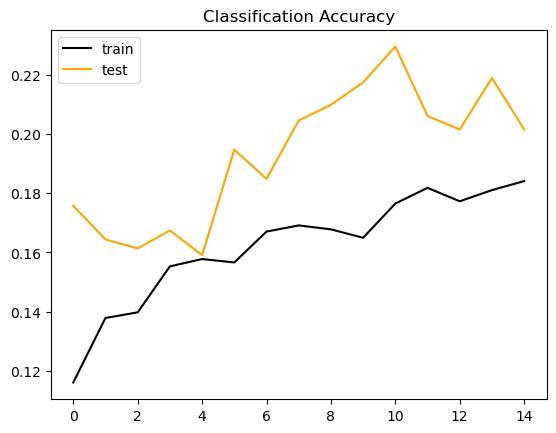

In [17]:
#Using Dropout on Hidden Layers
'''
If your input data is an image and your model is a classification model, 
you’ll want to define the input shape by the number of pixels and channels
'''

model = Sequential()
model.add(Dense(256, input_dim = X_train_norm.shape[1], activation= 'relu'))
model.add(Dropout(rate=0.4))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(11, activation = 'softmax'))
# compile the model and fit the model 
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history_model = model.fit(X_train_norm, y_train_norm, epochs=15, batch_size=32, validation_data=(X_test_norm, y_test_norm), verbose = 0)
#Returns the loss value & metrics values for the model in test mode.
_, acc = model.evaluate(X_test_norm, y_test_norm)
print('Test accuracy: %.3f' % acc)

# we can plot the metric history 
history_dict = history_model.history
plt.title('Classification Accuracy')
plt.plot(history_dict['accuracy'], color='black', label='train')
plt.plot(history_dict['val_accuracy'], color='orange', label='test')
plt.legend(loc='best')
plt.show()

#### Using Dropout on input layer

42/42 [==============================] - 0s 3ms/step - loss: 2.2653 - accuracy: 0.1288
Test accuracy: 0.129


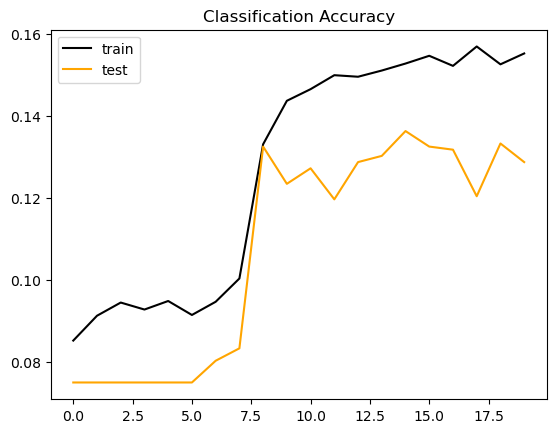

In [27]:
#Using Dropout on input layer

dropout_rate = 0.8
first_layout = 50
epochs = 150
batch_size = 32
activation = 'relu'
optimizer = 'rmsprop'
loss='categorical_crossentropy'
metrics=['accuracy']

model = Sequential()
model.add(Dropout(rate=dropout_rate, input_shape=(X_train_norm.shape[1],)))
model.add(Dense(first_layout, activation=activation))
model.add(Dense(11, activation = 'softmax'))
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

history_model = model.fit(X_train_norm, y_train_norm, epochs=20, batch_size=32, validation_data=(X_test_norm, y_test_norm), verbose = 0)
#Returns the loss value & metrics values for the model in test mode.
_, acc = model.evaluate(X_test_norm, y_test_norm)
print('Test accuracy: %.3f' % acc)

# we can plot the metric history 
history_dict = history_model.history
plt.title('Classification Accuracy')
plt.plot(history_dict['accuracy'], color='black', label='train')
plt.plot(history_dict['val_accuracy'], color='orange', label='test')
plt.legend(loc='best')
plt.show()

#### Fine Tune Keras Hyperparameter
Tutorial from https://ai.plainenglish.io/how-to-fine-tune-your-hyperparameter-with-keras-4efa852eecc5

In [47]:
#define the model
'''
SGD produces the same performance as regular gradient descent when the learning rate is low. 
Adam's optimization method computes individual adaptive learning rates 
for different parameters from estimates of the first and second moments of the gradients.
'''
def make_model(n_layers=1, n_neurons=100, learning_rate=1e-3, input_shape=(X_train_norm.shape[1],)):
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))
    for layer in range(n_layers):
        model.add(Dense(n_neurons, activation='relu'))
        model.add(Dropout(rate=0.4))
    model.add(Dense(11, activation='softmax'))
    model.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(learning_rate=learning_rate), 
                  metrics=['accuracy'])
    return model

'''
If we want to use sklearn to fine tune our hyperparameters, we must use a wrapper to wrap our model built by keras. 
Forntunately, it is quite simple since keras already has a wrapper for exactly this purpose:
'''
model = KerasClassifier(make_model)

#ry searching for a better set of parameters
'''
The default interpretation of the dropout hyperparameter is the probability of training a given node in a layer, 
where 1.0 means no dropout, and 0.0 means no outputs from the layer. 
A good value for dropout in a hidden layer is between 0.5 and 0.8. Input layers use a larger dropout rate, 
such as of 0.8.
'''
'''
The effect of learning rate: 
https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/
'''
param_distribs ={
    'n_layers': (1, 2, 3, 4, 5),
    'n_neurons': (50, 100, 150, 200, 250),
    'learning_rate':(1e-0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-7)
}
'''
The n_iter parameter will set the number of iterations it will randomly search for the best parameters
'''
rnd_search = RandomizedSearchCV(model, param_distribs, n_iter=10, cv=5)
rnd_search.fit(X_train_norm, y_train_norm, epochs=20, 
               validation_data=(X_test_norm, y_test_norm), 
               callbacks=[EarlyStopping(patience=10)])
rnd_search.best_params_
print("The best parameters are: 'n_neurons': 150, 'n_layers': 1, 'learning_rate': 0.0001")

Epoch 1/20
132/132 [==============================] - 3s 19ms/step - loss: 3.0044 - accuracy: 0.0838 - val_loss: 2.3980 - val_accuracy: 0.0811
Epoch 2/20
132/132 [==============================] - 1s 7ms/step - loss: 2.4013 - accuracy: 0.0921 - val_loss: 2.3983 - val_accuracy: 0.0811
Epoch 3/20
132/132 [==============================] - 1s 6ms/step - loss: 2.3979 - accuracy: 0.0897 - val_loss: 2.3986 - val_accuracy: 0.0811
Epoch 4/20
132/132 [==============================] - 1s 6ms/step - loss: 2.3979 - accuracy: 0.0893 - val_loss: 2.3988 - val_accuracy: 0.0811
Epoch 5/20
132/132 [==============================] - 1s 6ms/step - loss: 2.3979 - accuracy: 0.0928 - val_loss: 2.3990 - val_accuracy: 0.0894
Epoch 6/20
132/132 [==============================] - 1s 6ms/step - loss: 2.3979 - accuracy: 0.0902 - val_loss: 2.3991 - val_accuracy: 0.0894
Epoch 7/20
132/132 [==============================] - 1s 6ms/step - loss: 2.3978 - accuracy: 0.0919 - val_loss: 2.3993 - val_accuracy: 0.0894
Epoch

Epoch 15/20
132/132 [==============================] - 1s 7ms/step - loss: 2.2910 - accuracy: 0.1378 - val_loss: 2.2441 - val_accuracy: 0.1492
Epoch 16/20
132/132 [==============================] - 1s 7ms/step - loss: 2.2908 - accuracy: 0.1399 - val_loss: 2.2734 - val_accuracy: 0.1356
Epoch 17/20
132/132 [==============================] - 1s 6ms/step - loss: 2.2821 - accuracy: 0.1387 - val_loss: 2.2207 - val_accuracy: 0.1652
Epoch 18/20
132/132 [==============================] - 1s 7ms/step - loss: 2.3124 - accuracy: 0.1307 - val_loss: 2.2356 - val_accuracy: 0.1530
Epoch 19/20
132/132 [==============================] - 1s 7ms/step - loss: 2.2632 - accuracy: 0.1461 - val_loss: 2.2215 - val_accuracy: 0.1583
Epoch 20/20
33/33 [==============================] - 0s 3ms/step - loss: 2.2149 - accuracy: 0.1903
Epoch 1/20
132/132 [==============================] - 5s 35ms/step - loss: 3.4396 - accuracy: 0.0985 - val_loss: 2.3986 - val_accuracy: 0.0750
Epoch 2/20
132/132 [=======================

132/132 [==============================] - 2s 15ms/step - loss: 2.3993 - accuracy: 0.0959 - val_loss: 2.4008 - val_accuracy: 0.0750
Epoch 11/20
132/132 [==============================] - 1s 6ms/step - loss: 2.3996 - accuracy: 0.0916 - val_loss: 2.4009 - val_accuracy: 0.0750
Epoch 12/20
132/132 [==============================] - 1s 4ms/step - loss: 2.3997 - accuracy: 0.0935 - val_loss: 2.4017 - val_accuracy: 0.0750
Epoch 13/20
132/132 [==============================] - 1s 4ms/step - loss: 2.3995 - accuracy: 0.0954 - val_loss: 2.4020 - val_accuracy: 0.0750
Epoch 14/20
33/33 [==============================] - 0s 2ms/step - loss: 2.3994 - accuracy: 0.0843
Epoch 1/20
132/132 [==============================] - 2s 13ms/step - loss: 4.9691 - accuracy: 0.0890 - val_loss: 2.3976 - val_accuracy: 0.0977
Epoch 2/20
132/132 [==============================] - 1s 5ms/step - loss: 2.3994 - accuracy: 0.0919 - val_loss: 2.3984 - val_accuracy: 0.1023
Epoch 3/20
132/132 [==============================] - 1

132/132 [==============================] - 1s 5ms/step - loss: 2.4113 - accuracy: 0.0919 - val_loss: 2.4035 - val_accuracy: 0.0924
Epoch 3/20
132/132 [==============================] - 1s 4ms/step - loss: 2.4112 - accuracy: 0.0829 - val_loss: 2.4188 - val_accuracy: 0.0894
Epoch 4/20
132/132 [==============================] - 1s 4ms/step - loss: 2.4122 - accuracy: 0.0921 - val_loss: 2.4135 - val_accuracy: 0.0894
Epoch 5/20
132/132 [==============================] - 1s 4ms/step - loss: 2.4137 - accuracy: 0.0821 - val_loss: 2.4058 - val_accuracy: 0.0924
Epoch 6/20
132/132 [==============================] - 1s 4ms/step - loss: 2.4122 - accuracy: 0.0911 - val_loss: 2.4156 - val_accuracy: 0.0902
Epoch 7/20
132/132 [==============================] - 1s 4ms/step - loss: 2.4092 - accuracy: 0.0900 - val_loss: 2.4048 - val_accuracy: 0.0894
Epoch 8/20
132/132 [==============================] - 1s 4ms/step - loss: 2.4125 - accuracy: 0.0876 - val_loss: 2.4223 - val_accuracy: 0.0924
Epoch 9/20
132/13

Epoch 18/20
33/33 [==============================] - 0s 2ms/step - loss: 2.4102 - accuracy: 0.0956
Epoch 1/20
132/132 [==============================] - 2s 13ms/step - loss: 2.8324 - accuracy: 0.0848 - val_loss: 2.3984 - val_accuracy: 0.0750
Epoch 2/20
132/132 [==============================] - 1s 9ms/step - loss: 2.3981 - accuracy: 0.0850 - val_loss: 2.3986 - val_accuracy: 0.0750
Epoch 3/20
132/132 [==============================] - 1s 9ms/step - loss: 2.3984 - accuracy: 0.0840 - val_loss: 2.3992 - val_accuracy: 0.0894
Epoch 4/20
132/132 [==============================] - 1s 9ms/step - loss: 2.3980 - accuracy: 0.0881 - val_loss: 2.3994 - val_accuracy: 0.0811
Epoch 5/20
132/132 [==============================] - 1s 9ms/step - loss: 2.3986 - accuracy: 0.0904 - val_loss: 2.3995 - val_accuracy: 0.0811
Epoch 6/20
132/132 [==============================] - 2s 15ms/step - loss: 2.3985 - accuracy: 0.0840 - val_loss: 2.3997 - val_accuracy: 0.0750
Epoch 7/20
132/132 [===========================

132/132 [==============================] - 2s 12ms/step - loss: 2.3980 - accuracy: 0.0959 - val_loss: 2.4003 - val_accuracy: 0.0750
Epoch 11/20
33/33 [==============================] - 0s 4ms/step - loss: 2.3989 - accuracy: 0.0862
Epoch 1/20
132/132 [==============================] - 2s 14ms/step - loss: 2.2585 - accuracy: 0.2131 - val_loss: 1.9693 - val_accuracy: 0.3780
Epoch 2/20
132/132 [==============================] - 1s 9ms/step - loss: 2.0247 - accuracy: 0.2945 - val_loss: 1.8873 - val_accuracy: 0.4220
Epoch 3/20
132/132 [==============================] - 1s 9ms/step - loss: 1.9144 - accuracy: 0.3456 - val_loss: 1.7817 - val_accuracy: 0.4727
Epoch 4/20
132/132 [==============================] - 1s 9ms/step - loss: 1.8353 - accuracy: 0.3849 - val_loss: 1.6827 - val_accuracy: 0.4682
Epoch 5/20
132/132 [==============================] - 1s 9ms/step - loss: 1.7743 - accuracy: 0.4103 - val_loss: 1.6189 - val_accuracy: 0.5379
Epoch 6/20
132/132 [==============================] - 1s 1

132/132 [==============================] - 1s 9ms/step - loss: 1.5138 - accuracy: 0.4815 - val_loss: 1.4430 - val_accuracy: 0.5606
Epoch 15/20
132/132 [==============================] - 1s 9ms/step - loss: 1.4757 - accuracy: 0.5026 - val_loss: 1.3764 - val_accuracy: 0.5765
Epoch 16/20
132/132 [==============================] - 1s 9ms/step - loss: 1.4812 - accuracy: 0.4957 - val_loss: 1.3893 - val_accuracy: 0.5886
Epoch 17/20
132/132 [==============================] - 1s 10ms/step - loss: 1.4760 - accuracy: 0.4938 - val_loss: 1.3935 - val_accuracy: 0.5553
Epoch 18/20
132/132 [==============================] - 1s 9ms/step - loss: 1.4430 - accuracy: 0.5045 - val_loss: 1.3743 - val_accuracy: 0.5697
Epoch 19/20
132/132 [==============================] - 1s 10ms/step - loss: 1.4439 - accuracy: 0.5076 - val_loss: 1.3480 - val_accuracy: 0.5848
Epoch 20/20
33/33 [==============================] - 0s 4ms/step - loss: 1.3779 - accuracy: 0.5606
Epoch 1/20
132/132 [==============================] -

132/132 [==============================] - 1s 7ms/step - loss: 1.6467 - accuracy: 0.4375 - val_loss: 1.5715 - val_accuracy: 0.5235
Epoch 10/20
132/132 [==============================] - 1s 6ms/step - loss: 1.6254 - accuracy: 0.4472 - val_loss: 1.5538 - val_accuracy: 0.5159
Epoch 11/20
132/132 [==============================] - 1s 6ms/step - loss: 1.6396 - accuracy: 0.4366 - val_loss: 1.4962 - val_accuracy: 0.5326
Epoch 12/20
132/132 [==============================] - 1s 7ms/step - loss: 1.6007 - accuracy: 0.4590 - val_loss: 1.5779 - val_accuracy: 0.5030
Epoch 13/20
132/132 [==============================] - 1s 6ms/step - loss: 1.5878 - accuracy: 0.4482 - val_loss: 1.5062 - val_accuracy: 0.5038
Epoch 14/20
132/132 [==============================] - 1s 6ms/step - loss: 1.5751 - accuracy: 0.4569 - val_loss: 1.4810 - val_accuracy: 0.5227
Epoch 15/20
132/132 [==============================] - 1s 7ms/step - loss: 1.5766 - accuracy: 0.4605 - val_loss: 1.4626 - val_accuracy: 0.5439
Epoch 16/20

Epoch 5/20
132/132 [==============================] - 1s 8ms/step - loss: 2.0249 - accuracy: 0.2902 - val_loss: 1.9125 - val_accuracy: 0.4000
Epoch 6/20
132/132 [==============================] - 1s 7ms/step - loss: 2.0165 - accuracy: 0.2872 - val_loss: 1.8751 - val_accuracy: 0.4220
Epoch 7/20
132/132 [==============================] - 1s 6ms/step - loss: 1.9543 - accuracy: 0.3023 - val_loss: 1.8504 - val_accuracy: 0.4364
Epoch 8/20
132/132 [==============================] - 1s 6ms/step - loss: 1.9531 - accuracy: 0.3014 - val_loss: 1.8371 - val_accuracy: 0.4598
Epoch 9/20
132/132 [==============================] - 1s 6ms/step - loss: 1.9311 - accuracy: 0.3037 - val_loss: 1.8637 - val_accuracy: 0.4553
Epoch 10/20
132/132 [==============================] - 1s 6ms/step - loss: 1.8877 - accuracy: 0.3210 - val_loss: 1.7896 - val_accuracy: 0.4614
Epoch 11/20
132/132 [==============================] - 1s 6ms/step - loss: 1.8885 - accuracy: 0.3291 - val_loss: 1.6828 - val_accuracy: 0.4871
Epoc

33/33 [==============================] - 0s 5ms/step - loss: 1.8974 - accuracy: 0.3333
Epoch 1/20
132/132 [==============================] - 2s 12ms/step - loss: 2.4254 - accuracy: 0.1084 - val_loss: 2.3541 - val_accuracy: 0.1545
Epoch 2/20
132/132 [==============================] - 1s 9ms/step - loss: 2.3270 - accuracy: 0.1411 - val_loss: 2.2868 - val_accuracy: 0.1735
Epoch 3/20
132/132 [==============================] - 1s 9ms/step - loss: 2.3015 - accuracy: 0.1454 - val_loss: 2.2548 - val_accuracy: 0.1803
Epoch 4/20
132/132 [==============================] - 1s 9ms/step - loss: 2.2824 - accuracy: 0.1634 - val_loss: 2.2384 - val_accuracy: 0.1311
Epoch 5/20
132/132 [==============================] - 1s 9ms/step - loss: 2.2642 - accuracy: 0.1693 - val_loss: 2.1962 - val_accuracy: 0.1629
Epoch 6/20
132/132 [==============================] - 1s 10ms/step - loss: 2.2460 - accuracy: 0.1657 - val_loss: 2.1874 - val_accuracy: 0.1902
Epoch 7/20
132/132 [==============================] - 1s 9m

132/132 [==============================] - 1s 10ms/step - loss: 2.3978 - accuracy: 0.0973 - val_loss: 2.3983 - val_accuracy: 0.0750
Epoch 5/20
132/132 [==============================] - 1s 9ms/step - loss: 2.3978 - accuracy: 0.0971 - val_loss: 2.3984 - val_accuracy: 0.0750
Epoch 6/20
132/132 [==============================] - 1s 9ms/step - loss: 2.3981 - accuracy: 0.0949 - val_loss: 2.3985 - val_accuracy: 0.0750
Epoch 7/20
132/132 [==============================] - 1s 9ms/step - loss: 2.3977 - accuracy: 0.0968 - val_loss: 2.3986 - val_accuracy: 0.0750
Epoch 8/20
132/132 [==============================] - 1s 9ms/step - loss: 2.3977 - accuracy: 0.0971 - val_loss: 2.3987 - val_accuracy: 0.0750
Epoch 9/20
132/132 [==============================] - 2s 12ms/step - loss: 2.3977 - accuracy: 0.0971 - val_loss: 2.3989 - val_accuracy: 0.0750
Epoch 10/20
132/132 [==============================] - 1s 10ms/step - loss: 2.3977 - accuracy: 0.0971 - val_loss: 2.3989 - val_accuracy: 0.0750
Epoch 11/20
3

132/132 [==============================] - 1s 6ms/step - loss: 2.4074 - accuracy: 0.0975 - val_loss: 2.3994 - val_accuracy: 0.0750
Epoch 4/20
132/132 [==============================] - 1s 6ms/step - loss: 2.3978 - accuracy: 0.0956 - val_loss: 2.3997 - val_accuracy: 0.0750
Epoch 5/20
132/132 [==============================] - 1s 6ms/step - loss: 2.3978 - accuracy: 0.0956 - val_loss: 2.4000 - val_accuracy: 0.0750
Epoch 6/20
132/132 [==============================] - 1s 6ms/step - loss: 2.3977 - accuracy: 0.0973 - val_loss: 2.4002 - val_accuracy: 0.0750
Epoch 7/20
132/132 [==============================] - 1s 6ms/step - loss: 2.3979 - accuracy: 0.0971 - val_loss: 2.4001 - val_accuracy: 0.0750
Epoch 8/20
132/132 [==============================] - 1s 6ms/step - loss: 2.3977 - accuracy: 0.0971 - val_loss: 2.4002 - val_accuracy: 0.0750
Epoch 9/20
132/132 [==============================] - 1s 6ms/step - loss: 2.3978 - accuracy: 0.0971 - val_loss: 2.4002 - val_accuracy: 0.0750
Epoch 10/20
132/1

132/132 [==============================] - 3s 23ms/step - loss: 2.4130 - accuracy: 0.0885 - val_loss: 2.4236 - val_accuracy: 0.0909
Epoch 16/20
132/132 [==============================] - 4s 30ms/step - loss: 2.4089 - accuracy: 0.0914 - val_loss: 2.4139 - val_accuracy: 0.0909
Epoch 17/20
132/132 [==============================] - 3s 22ms/step - loss: 2.4129 - accuracy: 0.0961 - val_loss: 2.4199 - val_accuracy: 0.0917
Epoch 18/20
132/132 [==============================] - 3s 20ms/step - loss: 2.4150 - accuracy: 0.0836 - val_loss: 2.4133 - val_accuracy: 0.0758
Epoch 19/20
132/132 [==============================] - 2s 19ms/step - loss: 2.4118 - accuracy: 0.0904 - val_loss: 2.4014 - val_accuracy: 0.0818
Epoch 20/20
33/33 [==============================] - 0s 7ms/step - loss: 2.4031 - accuracy: 0.0862
Epoch 1/20
132/132 [==============================] - 6s 48ms/step - loss: 8494.1865 - accuracy: 0.0911 - val_loss: 2.4051 - val_accuracy: 0.0992
Epoch 2/20
132/132 [===========================

33/33 [==============================] - 0s 3ms/step - loss: 2.3988 - accuracy: 0.0881
Epoch 1/20
132/132 [==============================] - 2s 14ms/step - loss: 4.0046 - accuracy: 0.0938 - val_loss: 2.4013 - val_accuracy: 0.0750
Epoch 2/20
132/132 [==============================] - 1s 7ms/step - loss: 2.4000 - accuracy: 0.0895 - val_loss: 2.4018 - val_accuracy: 0.0750
Epoch 3/20
132/132 [==============================] - 1s 7ms/step - loss: 2.3991 - accuracy: 0.0921 - val_loss: 2.4033 - val_accuracy: 0.0750
Epoch 4/20
132/132 [==============================] - 1s 10ms/step - loss: 2.3994 - accuracy: 0.0916 - val_loss: 2.4014 - val_accuracy: 0.0750
Epoch 5/20
132/132 [==============================] - 1s 7ms/step - loss: 2.3992 - accuracy: 0.0945 - val_loss: 2.3994 - val_accuracy: 0.0750
Epoch 6/20
132/132 [==============================] - 1s 7ms/step - loss: 2.3999 - accuracy: 0.0866 - val_loss: 2.3998 - val_accuracy: 0.0902
Epoch 7/20
132/132 [==============================] - 2s 13

Epoch 13/20
165/165 [==============================] - 2s 10ms/step - loss: 1.5637 - accuracy: 0.4631 - val_loss: 1.4210 - val_accuracy: 0.5561
Epoch 14/20
165/165 [==============================] - 2s 9ms/step - loss: 1.5665 - accuracy: 0.4608 - val_loss: 1.3910 - val_accuracy: 0.5682
Epoch 15/20
165/165 [==============================] - 2s 9ms/step - loss: 1.5629 - accuracy: 0.4629 - val_loss: 1.4882 - val_accuracy: 0.5212
Epoch 16/20
165/165 [==============================] - 2s 9ms/step - loss: 1.5483 - accuracy: 0.4678 - val_loss: 1.3956 - val_accuracy: 0.5432
Epoch 17/20
165/165 [==============================] - 1s 9ms/step - loss: 1.5459 - accuracy: 0.4614 - val_loss: 1.4205 - val_accuracy: 0.5697
Epoch 18/20
165/165 [==============================] - 2s 9ms/step - loss: 1.5204 - accuracy: 0.4803 - val_loss: 1.4219 - val_accuracy: 0.5780
Epoch 19/20
165/165 [==============================] - 2s 11ms/step - loss: 1.5142 - accuracy: 0.4778 - val_loss: 1.3956 - val_accuracy: 0.58

{'n_neurons': 150, 'n_layers': 1, 'learning_rate': 0.0001}

42/42 [==============================] - 0s 10ms/step - loss: 1.3274 - accuracy: 0.5977
Test accuracy: 0.598


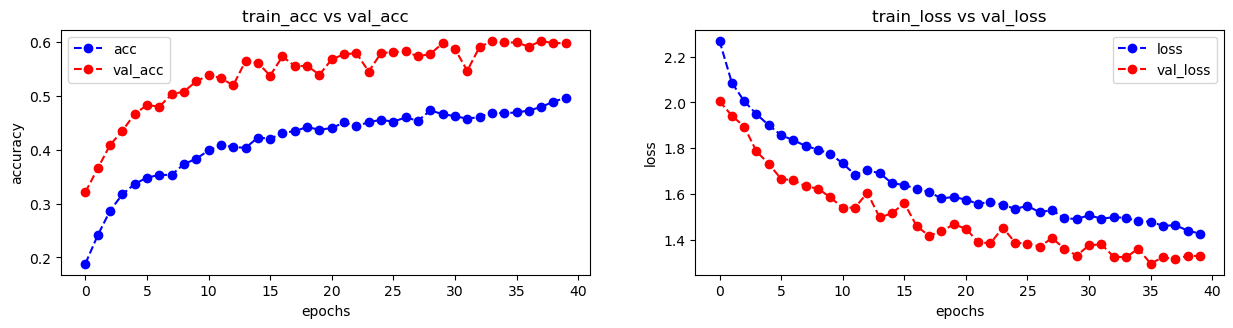

In [54]:
#Based on the previous randomized parameter search, we get the best parameters
n_neurons = 150
n_layers = 1
learning_rate = 0.0001

def make_model(n_layers=1, n_neurons=100, learning_rate=1e-3, input_shape=(X_train_norm.shape[1],)):
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))
    for layer in range(n_layers):
        model.add(Dense(n_neurons, activation='relu'))
        model.add(Dropout(rate=0.4))
    model.add(Dense(11, activation='softmax'))
    model.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(learning_rate=learning_rate), 
                  metrics=['accuracy'])
    return model

final_model = make_model(n_layers=1, n_neurons=150, learning_rate=0.0001, input_shape=(X_train_norm.shape[1],))

history_model = final_model.fit(X_train_norm, y_train_norm, epochs=40, batch_size=32, validation_data=(X_test_norm, y_test_norm), verbose = 0)
#Returns the loss value & metrics values for the model in test mode.
_, acc = final_model.evaluate(X_test_norm, y_test_norm)
print('Test accuracy: %.3f' % acc)

# we can plot the metric history 
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(15,7))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()
    
plot_accuracy_loss(history_model)

'''
The reason why we see higher validaiton accuracy rate than the training accuracy rate:
This happens when you use Dropout, since the behaviour when training and testing are different.

When training, a percentage of the features are set to zero (40% because we are using Dropout(0.4)).
When testing, all features are used (and are scaled appropriately). 
So the model at test time is more robust - and can lead to higher testing accuracies.
'''

#### CNN

Steps are:

1. Build the model,
2. Compile the model,
3. Train / fit the data to the model,
4. Evaluate the model on the testing set,
5. Carry out an error analysis of our model.

We can build an easy model composed of different layers such as:

1. Conv2D: (32 filters of size 3 by 3) The features will be "extracted" from the image.
2. MaxPooling2D: The images get half sized.
3. Flatten: Transforms the format of the images from a 2d-array to a 1d-array of 150 150 pixel values.
4. Relu : given a value x, returns max(x, 0).
5. Softmax: 11 neurons, probability that the image belongs to one of the classes.

Epoch 1/20
43/43 [==============================] - 33s 766ms/step - loss: 2.0293 - accuracy: 0.3890 - val_loss: 1.3201 - val_accuracy: 0.6070
Epoch 2/20
43/43 [==============================] - 35s 816ms/step - loss: 1.1193 - accuracy: 0.6648 - val_loss: 1.1260 - val_accuracy: 0.6487
Epoch 3/20
43/43 [==============================] - 35s 821ms/step - loss: 0.7530 - accuracy: 0.7734 - val_loss: 0.9162 - val_accuracy: 0.7282
Epoch 4/20
43/43 [==============================] - 32s 745ms/step - loss: 0.4956 - accuracy: 0.8537 - val_loss: 0.9244 - val_accuracy: 0.7377
Epoch 5/20
43/43 [==============================] - 32s 744ms/step - loss: 0.3058 - accuracy: 0.9183 - val_loss: 0.9536 - val_accuracy: 0.7377
Epoch 6/20
43/43 [==============================] - 32s 743ms/step - loss: 0.2001 - accuracy: 0.9463 - val_loss: 1.0455 - val_accuracy: 0.7339
Epoch 7/20
43/43 [==============================] - 33s 775ms/step - loss: 0.1069 - accuracy: 0.9770 - val_loss: 1.0616 - val_accuracy: 0.7481

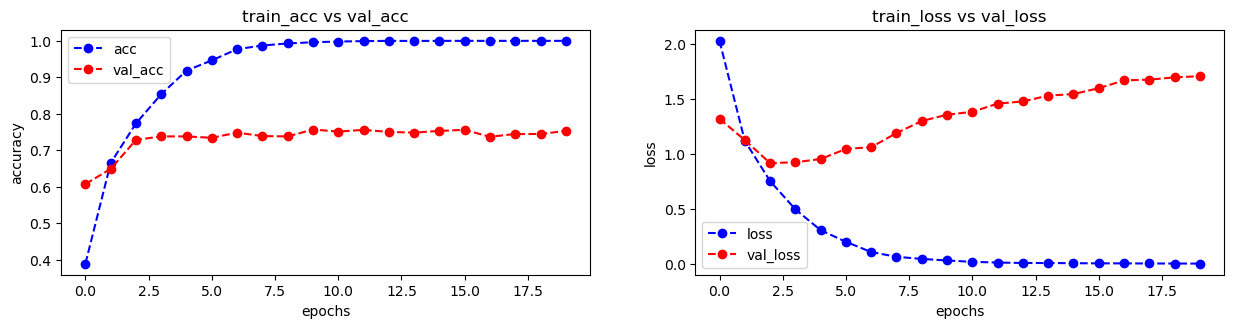

In [62]:
# Split the dataset into training (80%) and testing (20%)
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(images_r_g, labels_r, test_size=0.2, random_state=2023)

# Normalization
X_train_norm_cnn = X_train/255.0
X_test_norm_cnn = X_test/255.0
#tf.keras.layers.Conv2D is expecting 3 dimensions for each image
X_train_norm_cnn= X_train_norm_cnn.reshape(-1,150,150,1)
X_test_norm_cnn= X_test_norm_cnn.reshape(-1,150,150,1)

'''
Keras Conv2D is a 2D Convolution Layer, https://www.geeksforgeeks.org/keras-conv2d-class/
this layer creates a convolution kernel that is wind with layers input which helps produce a tensor of outputs.
'''
'''
Max pooling: This works by selecting the maximum value from every pool. Max Pooling retains 
the most prominent features of the feature map, and the returned image is sharper than the original image. 
Average pooling: This pooling layer works by getting the average of the pool.
'''
'''
use input_shape = (150, 150, 1) rather than input_shape = (150, 150)
The problem is with input_shape. 
Try adding an extra dimension/channel for letting keras know that you are working on a grayscale image ie -->1

input_shape= (56,56,1). Probably if you are using a normal Deep learning model then it won't raise an issue but for Convnet it does.
'''
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 1)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(11, activation=tf.nn.softmax)
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_norm_cnn, y_train_cnn, batch_size=100, epochs=20, validation_split = 0.2)
#Returns the loss value & metrics values for the model in test mode.
_, acc = model.evaluate(X_test_norm_cnn, y_test_cnn)
print('Test accuracy: %.3f' % acc)
plot_accuracy_loss(history)

Epoch 1/20
43/43 [==============================] - 38s 892ms/step - loss: 2.6871 - accuracy: 0.1359 - val_loss: 2.3765 - val_accuracy: 0.1468
Epoch 2/20
43/43 [==============================] - 36s 845ms/step - loss: 1.8332 - accuracy: 0.4100 - val_loss: 1.5504 - val_accuracy: 0.5398
Epoch 3/20
43/43 [==============================] - 36s 841ms/step - loss: 1.2373 - accuracy: 0.6207 - val_loss: 1.2753 - val_accuracy: 0.6411
Epoch 4/20
43/43 [==============================] - 35s 819ms/step - loss: 0.9800 - accuracy: 0.7019 - val_loss: 1.0757 - val_accuracy: 0.7083
Epoch 5/20
43/43 [==============================] - 35s 822ms/step - loss: 0.7835 - accuracy: 0.7590 - val_loss: 1.0889 - val_accuracy: 0.6771
Epoch 6/20
43/43 [==============================] - 35s 822ms/step - loss: 0.6104 - accuracy: 0.8123 - val_loss: 1.0168 - val_accuracy: 0.7102
Epoch 7/20
43/43 [==============================] - 36s 830ms/step - loss: 0.4746 - accuracy: 0.8518 - val_loss: 0.9478 - val_accuracy: 0.7330

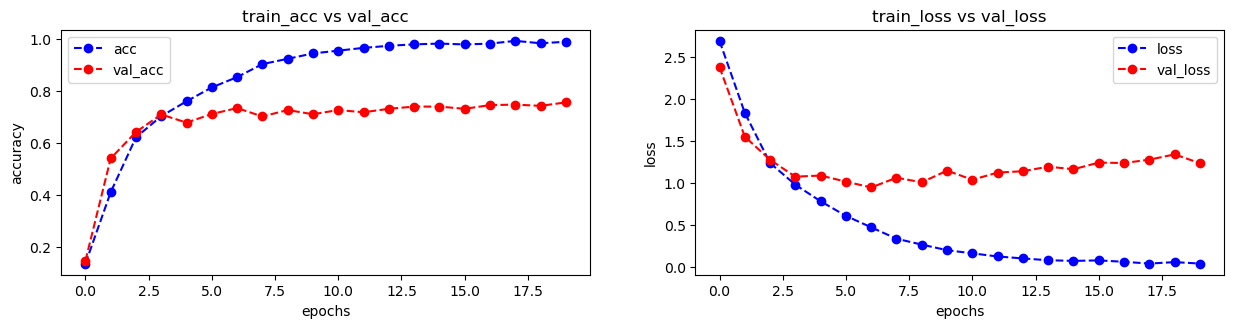

In [63]:
'''
From last CNN model, we get a decent accuracy rate (0.745) for our testing dataset.
However, because the model has a way higher training accuracy than validation accuracy, which may imply overfitting. 
We will try to add dropout layer in the model as well, and reduce the learning rate.
'''

# Split the dataset into training (80%) and testing (20%)
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(images_r_g, labels_r, test_size=0.2, random_state=2023)

# Normalization
X_train_norm_cnn = X_train/255.0
X_test_norm_cnn = X_test/255.0
#tf.keras.layers.Conv2D is expecting 3 dimensions for each image
X_train_norm_cnn= X_train_norm_cnn.reshape(-1,150,150,1)
X_test_norm_cnn= X_test_norm_cnn.reshape(-1,150,150,1)

'''
Keras Conv2D is a 2D Convolution Layer, https://www.geeksforgeeks.org/keras-conv2d-class/
this layer creates a convolution kernel that is wind with layers input which helps produce a tensor of outputs.
'''
'''
Max pooling: This works by selecting the maximum value from every pool. Max Pooling retains 
the most prominent features of the feature map, and the returned image is sharper than the original image. 
Average pooling: This pooling layer works by getting the average of the pool.
'''
'''
use input_shape = (150, 150, 1) rather than input_shape = (150, 150)
The problem is with input_shape. 
Try adding an extra dimension/channel for letting keras know that you are working on a grayscale image ie -->1

input_shape= (56,56,1). Probably if you are using a normal Deep learning model then it won't raise an issue but for Convnet it does.
'''
'''
Dropout can be used after convolutional layers (e.g. Conv2D) and after pooling layers (e.g. MaxPooling2D).
Often, dropout is only used after the pooling layers, but this is just a rough heuristic.
'''
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 1)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(11, activation=tf.nn.softmax)
])
'''
Loss function: we use sparse categorical crossentropy for classification, each images belongs to one class only
'''
model.compile(optimizer=Adam(learning_rate=0.001), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_norm_cnn, y_train_cnn, batch_size=100, epochs=20, validation_split = 0.2)
#Returns the loss value & metrics values for the model in test mode.
_, acc = model.evaluate(X_test_norm_cnn, y_test_cnn)
print('Test accuracy: %.3f' % acc)
plot_accuracy_loss(history)

#### Error Analysis
In this seciton, we are curious to see what kind of images are misclassified by the model.

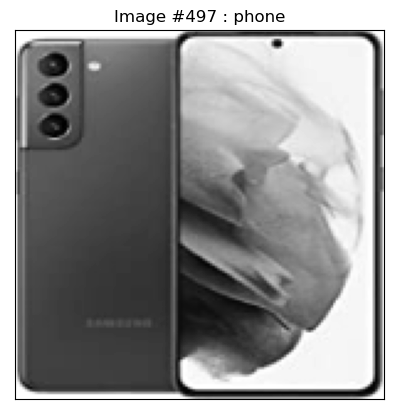

In [86]:
#Use the model to predict the test images
#predicitons.shape[0] is the same as X_test_norm_cnn.shape[0]
predicitons = model.predict(X_test_norm_cnn)
# We take the highest probability
pred_labels = np.argmax(predicitons, axis = 1)

#Define a function to display a random image.
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index], cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()
#Display this random image
display_random_image(class_names, X_test_cnn, pred_labels)

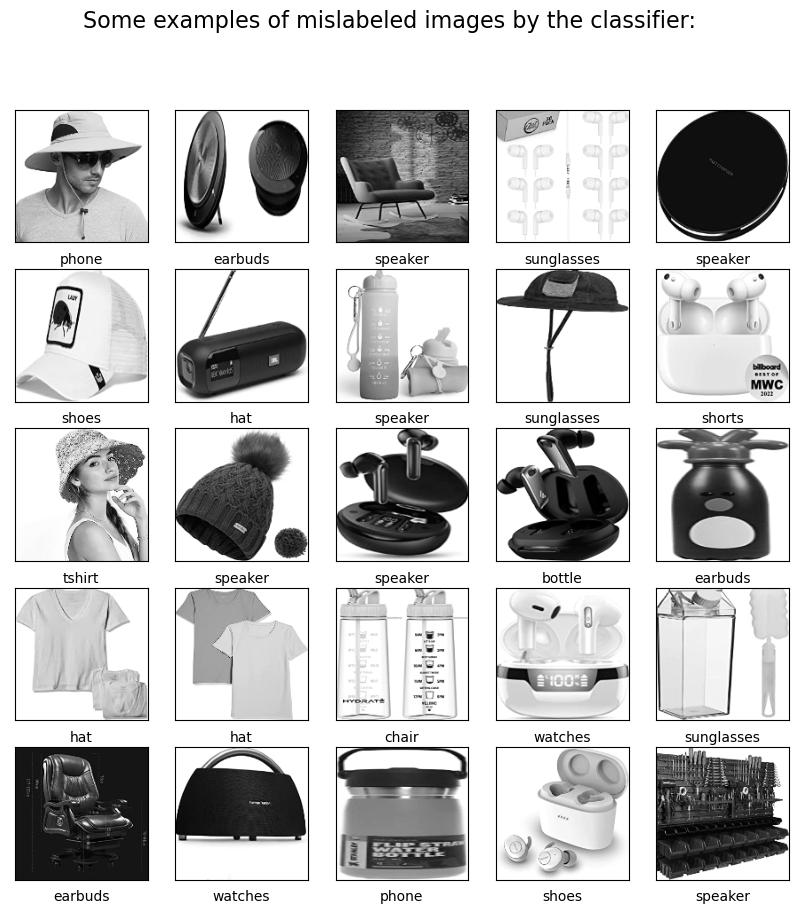

In [102]:
#Print out those images that has wrong prediciton label

def display_examples(class_names, images, labels, suptitle):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle(suptitle, fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.xlabel(class_names[labels[i]])
    plt.show()

def print_mislabeled_images(class_names, test_images, test_labels, pred_labels, suptitle):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]
    
    display_examples(class_names,  mislabeled_images, mislabeled_labels, suptitle)

title = "Some examples of mislabeled images by the classifier:"
print_mislabeled_images(class_names, X_test_cnn, y_test_cnn, pred_labels, title)

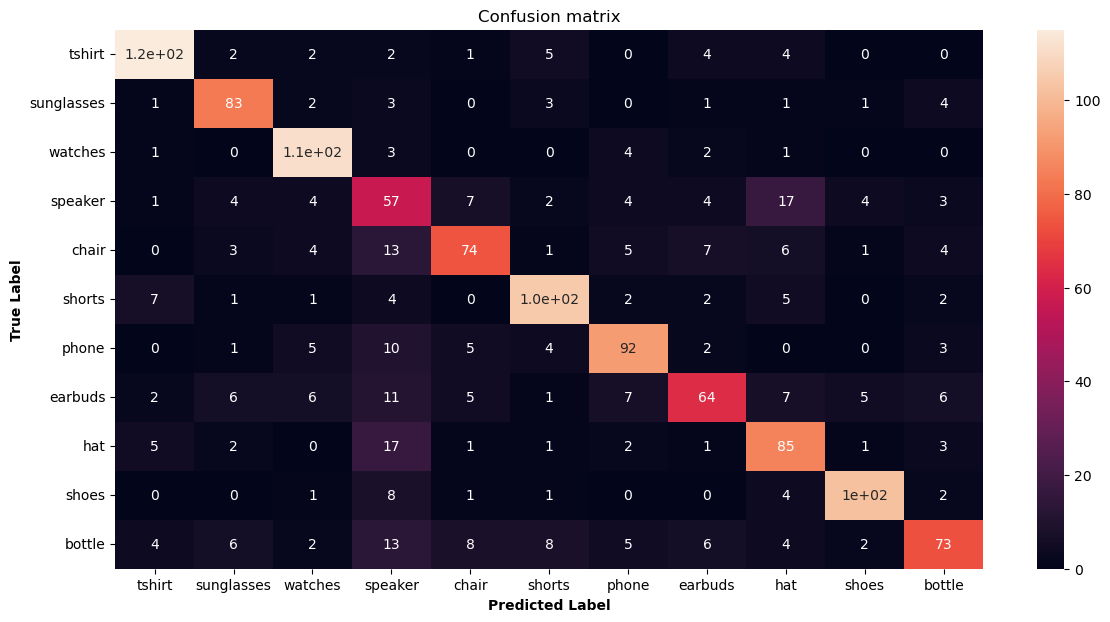

In [107]:
#confusion matrix
'''
Y is true labe, X is predicted label
'''
import seaborn as sn
fig, ax = plt.subplots(figsize=(14,7))
CM = confusion_matrix(y_test_cnn, pred_labels)
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
ax.set_xlabel("Predicted Label",fontweight ='bold')
ax.set_ylabel("True Label",fontweight ='bold')

plt.show()